In [1]:
!pip install datasets>=2.6.1
!pip install librosa
!pip install evaluate>=0.30
!pip install jiwer

In [2]:
from huggingface_hub import notebook_login
notebook_login()

In [19]:
import datasets
print(datasets.__version__)  # Check if it's installed correctly


3.1.0


In [25]:
pip uninstall torch torchvision torchaudio -y


Found existing installation: torch 2.4.1
Uninstalling torch-2.4.1:
  Successfully uninstalled torch-2.4.1
Found existing installation: torchvision 0.17.2
Uninstalling torchvision-0.17.2:
  Successfully uninstalled torchvision-0.17.2
Found existing installation: torchaudio 2.2.2+cu121
Uninstalling torchaudio-2.2.2+cu121:
  Successfully uninstalled torchaudio-2.2.2+cu121
Note: you may need to restart the kernel to use updated packages.


You can safely remove it manually.
You can safely remove it manually.


In [27]:
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121


Looking in indexes: https://download.pytorch.org/whl/cu121
     ---------------------------------------- 0.0/2.4 GB ? eta -:--:--
     ---------------------------------------- 0.0/2.4 GB 8.4 MB/s eta 0:04:52
     ---------------------------------------- 0.0/2.4 GB 10.6 MB/s eta 0:03:51
     ---------------------------------------- 0.0/2.4 GB 8.9 MB/s eta 0:04:35
     ---------------------------------------- 0.0/2.4 GB 9.6 MB/s eta 0:04:13
     ---------------------------------------- 0.0/2.4 GB 10.1 MB/s eta 0:04:03
     ---------------------------------------- 0.0/2.4 GB 10.6 MB/s eta 0:03:51
     ---------------------------------------- 0.0/2.4 GB 10.7 MB/s eta 0:03:47
     ---------------------------------------- 0.0/2.4 GB 10.8 MB/s eta 0:03:44
     ---------------------------------------- 0.0/2.4 GB 10.9 MB/s eta 0:03:42
     ---------------------------------------- 0.0/2.4 GB 11.1 MB/s eta 0:03:40
     ---------------------------------------- 0.0/2.4 GB 11.1 MB/s eta 0:03:38
    

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.7.15 requires torch<2.4,>=1.10, but you have torch 2.4.1+cu121 which is incompatible.
tsai 0.3.9 requires torch<2.3,>=1.10, but you have torch 2.4.1+cu121 which is incompatible.


     ---------------------------------------  2.4/2.4 GB 11.6 MB/s eta 0:00:06
     ---------------------------------------  2.4/2.4 GB 11.6 MB/s eta 0:00:05
     ---------------------------------------  2.4/2.4 GB 11.6 MB/s eta 0:00:05
     ---------------------------------------  2.4/2.4 GB 11.6 MB/s eta 0:00:05
     ---------------------------------------  2.4/2.4 GB 11.6 MB/s eta 0:00:05
     ---------------------------------------  2.4/2.4 GB 11.6 MB/s eta 0:00:05
     ---------------------------------------  2.4/2.4 GB 11.6 MB/s eta 0:00:04
     ---------------------------------------  2.4/2.4 GB 11.6 MB/s eta 0:00:04
     ---------------------------------------  2.4/2.4 GB 11.6 MB/s eta 0:00:04
     ---------------------------------------  2.4/2.4 GB 11.6 MB/s eta 0:00:04
     ---------------------------------------  2.4/2.4 GB 11.6 MB/s eta 0:00:03
     ---------------------------------------  2.4/2.4 GB 11.5 MB/s eta 0:00:03
     ---------------------------------------  2.4/2.

In [39]:
pip install torchvision

Note: you may need to restart the kernel to use updated packages.


In [41]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [1]:
import torch

print(torch.__version__)      # Should print the installed version
  # Should print the installed version


2.4.1+cu121


In [2]:
import torchvision

In [3]:
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio
from scipy.signal import resample
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader


from transformers import WhisperTokenizer
from transformers import WhisperFeatureExtractor
from transformers import WhisperForConditionalGeneration

import evaluate

wer  = evaluate.load('wer')

from scipy.signal import resample

def down_sample_audio(audio_original, original_sample_rate):
    target_sample_rate = 16000

    # Calculate the number of samples for the target sample rate
    num_samples = int(len(audio_original) * target_sample_rate / original_sample_rate)

    # Resample the audio array to the target sample rate
    downsampled_audio = resample(audio_original, num_samples)

    return downsampled_audio

In [4]:
from transformers import WhisperTokenizer
from transformers import WhisperFeatureExtractor
from transformers import WhisperForConditionalGeneration

tokenizer = WhisperTokenizer.from_pretrained("openai/whisper-small",language='english',task='transcribe')
feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-small",language='english',task='transcribe')
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small").to('cuda')

In [5]:
from datasets import load_dataset
atco_asr_data = load_dataset('parquet',data_files="C:/Users/WORKSTATIONS/Desktop/BijoyashreeDas/atc/train-00000-of-00005-c6681348ac8543dc.parquet")

## Find WER on first 200 samples of validation set before finetuning

In [14]:
import jiwer

# Load validation dataset
atco_asr_data = load_dataset('parquet', data_files="C:/Users/WORKSTATIONS/Desktop/BijoyashreeDas/atc/validation-00000-of-00002-7a5ea3756991bf72.parquet")

# Put model in evaluation mode
model.eval()

# Initialize WER metric
wer_metric = jiwer.wer
total_wer = []
total_samples = min(200, len(atco_asr_data['train']))  # Ensure at most 200 samples

# Compute WER on first 200 samples
for idx in range(total_samples):
    sample = atco_asr_data['train'][idx]
    target = sample['text']
    audio_original = sample['audio']['array']

    # Extract input features
    input_feature = feature_extractor(
        raw_speech=audio_original,
        sampling_rate=16000,
        return_tensors='pt'
    ).input_features

    # Generate transcription
    with torch.no_grad():
        op = model.generate(input_feature.to('cuda'), language='english', task='transcribe')

    text_pred = tokenizer.batch_decode(op, skip_special_tokens=True)[0]

    # Compute WER for this sample
    wer_score = wer_metric(target, text_pred)
    total_wer.append(wer_score)

    # Print progress every 50 samples
    if idx % 50 == 0:
        print(f'Processed {idx}/{total_samples} samples')

# Compute final average WER
avg_wer = sum(total_wer) / len(total_wer)
print(f'\nFinal Average WER for First 200 Validation Samples (Before Fine-Tuning): {avg_wer:.4f}')

You have passed task=transcribe, but also have set `forced_decoder_ids` to [[1, None], [2, 50359]] which creates a conflict. `forced_decoder_ids` will be ignored in favor of task=transcribe.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
C:\Users\WORKSTATIONS\anaconda3\lib\site-packages\transformers\models\whisper\modeling_whisper.py:545: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Processed 0/200 samples
Processed 50/200 samples
Processed 100/200 samples
Processed 150/200 samples

Final Average WER for First 200 Validation Samples (Before Fine-Tuning): 1.2165


# Find out the maximum length of transcription present in the training dataset

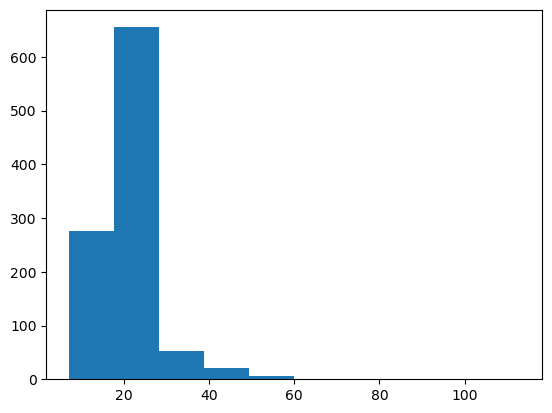

In [16]:
list_of_transcription_lengths = []

for sample in atco_asr_data['train']:
    text = sample['text']
    tokenized_text = tokenizer(text).input_ids
    list_of_transcription_lengths.append(len(tokenized_text))
    # break

plt.hist(list_of_transcription_lengths)
plt.show()

In [18]:

class whisper_training_dataset(torch.utils.data.Dataset):
    def __init__(self, dataset, max_len):#daatset is huggingface dataset object
        self.dataset = dataset
        self.max_len = max_len
        self.bos_token = model.config.decoder_start_token_id

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]

        audio_data = down_sample_audio(item['audio']["array"], item['audio']["sampling_rate"])
        input_features = feature_extractor(audio_data, sampling_rate=16000,return_tensors='pt').input_features[0]

        # Process the transcription
        transcription = item["text"]

        # Create labels
        labels = tokenizer(transcription, padding="max_length", max_length=self.max_len, truncation=True, return_tensors="pt")
        labels = labels["input_ids"].masked_fill(labels['attention_mask'].ne(1), -100)
        labels = labels[0][1:]


        return {
            "input_features": input_features,
            "labels": labels
        }

In [20]:
dataset = whisper_training_dataset(dataset=atco_asr_data['train'], max_len=60)

train_dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=8,  # Adjust batch size as needed
    shuffle=True,  # Shuffle data during training
)

In [22]:
def evaluation(model):

    atco_asr_data = load_dataset('parquet',data_files="C:/Users/WORKSTATIONS/Desktop/BijoyashreeDas/atc/train-00000-of-00005-c6681348ac8543dc.parquet")

    model.eval()

    predictions=[]
    references=[]

    for sample in tqdm(atco_asr_data['train'],total=len(atco_asr_data['train'])):
        audio=sample['audio']['array']
        sample_rate=sample['audio']['sampling_rate']
        text=sample['text']

        audio = down_sample_audio(audio, sample_rate) # downsample the audio to 16000Hz for WHISPER

        input_features = feature_extractor(
        raw_speech=audio,
        sampling_rate=16000,
        return_tensors='pt',
        padding=True).input_features

        # Generate predictions with no gradient computation
        with torch.no_grad():
            op = model.generate(input_features.to('cuda'), language='english', task='transcribe')

        # Decode predictions
        text_preds = tokenizer.batch_decode(op, skip_special_tokens=True)

        # Append batch predictions and references to the respective lists
        predictions.extend(text_preds)
        references.extend([text])

    WER = wer.compute(predictions=predictions, references=references) * 100

    return WER



WER was 5% for epoch 1 when tested for 5 total epochs, but for 10 epochs the WER went to 35% at epoch 1. why
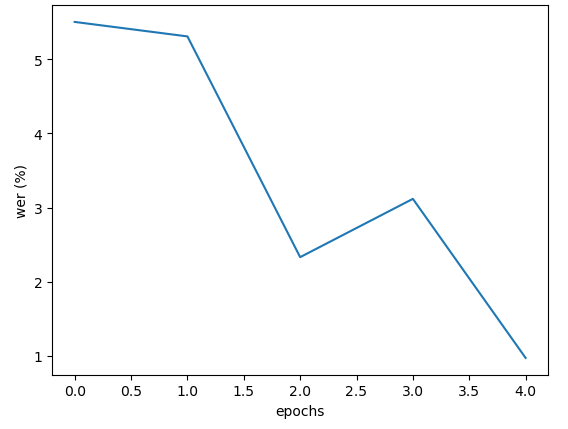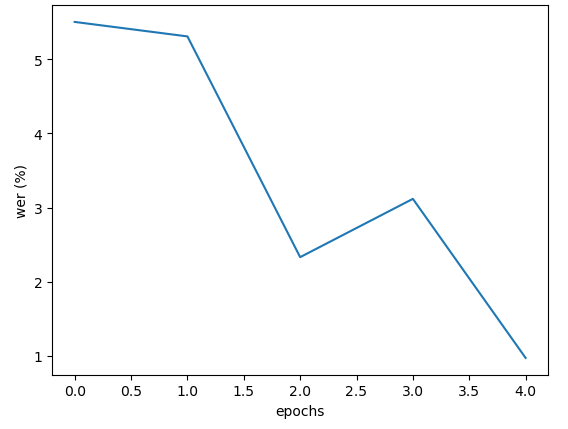

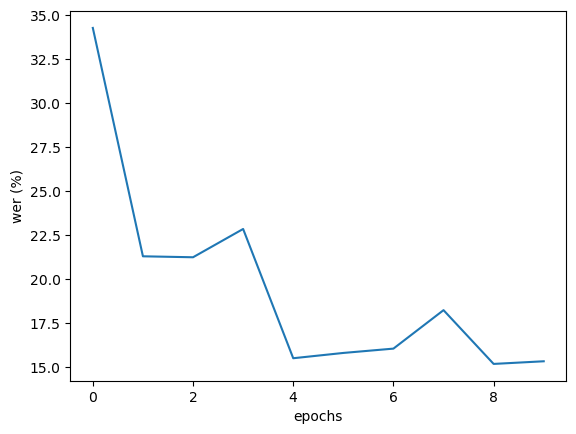

100%|███████████████████████████████████████████████████████████████████████████████| 10/10 [2:09:21<00:00, 776.12s/it]


In [24]:
from IPython.display import clear_output

device='cuda'

optimizer=torch.optim.AdamW(model.parameters(), lr=1e-5)

max_epochs=10


running_wer=[]



for epoch in tqdm(range(max_epochs)):

    for batch in train_dataloader:

        model.train()  # Set model to training mode

        input_features, labels = batch["input_features"].to(device), batch["labels"].to(device)

        # Forward pass
        outputs = model(input_features, labels=labels)  # Assuming your model takes these inputs
        loss = outputs.loss

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()  # Reset gradients

   
        
  
    running_wer.append(evaluation(model))
    plt.plot(running_wer)
    clear_output(wait=True)
    plt.xlabel('epochs')
    plt.ylabel('wer (%)')
    plt.show()
    


In [25]:
torch.save(model.state_dict(), 'finetuned_atco.pth')# saving the model
import torch
model.load_state_dict(torch.load('finetuned_atco.pth', weights_only=True))# loading the model
model.eval()
model.to('cuda')

WhisperForConditionalGeneration(
  (model): WhisperModel(
    (encoder): WhisperEncoder(
      (conv1): Conv1d(80, 768, kernel_size=(3,), stride=(1,), padding=(1,))
      (conv2): Conv1d(768, 768, kernel_size=(3,), stride=(2,), padding=(1,))
      (embed_positions): Embedding(1500, 768)
      (layers): ModuleList(
        (0-11): 12 x WhisperEncoderLayer(
          (self_attn): WhisperSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=False)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
        

## View train and validation parquet files

In [19]:
import pandas as pd

df = pd.read_parquet("C:/Users/WORKSTATIONS/Desktop/BijoyashreeDas/atc/train-00000-of-00005-c6681348ac8543dc.parquet")
print(df)


                                                  audio  \
0     {'bytes': b'RIFF$\x98\x03\x00WAVEfmt \x10\x00\...   
1     {'bytes': b'RIFF$\x90\x05\x00WAVEfmt \x10\x00\...   
2     {'bytes': b'RIFF$\xf0\x02\x00WAVEfmt \x10\x00\...   
3     {'bytes': b'RIFF$x\x03\x00WAVEfmt \x10\x00\x00...   
4     {'bytes': b'RIFF$\x80\x07\x00WAVEfmt \x10\x00\...   
...                                                 ...   
1614  {'bytes': b'RIFFl\xa8\x04\x00WAVEfmt \x10\x00\...   
1615  {'bytes': b'RIFFR\xee\x03\x00WAVEfmt \x10\x00\...   
1616  {'bytes': b'RIFFtS\x03\x00WAVEfmt \x10\x00\x00...   
1617  {'bytes': b'RIFF\x1c.\x04\x00WAVEfmt \x10\x00\...   
1618  {'bytes': b'RIFF&\xb3\x03\x00WAVEfmt \x10\x00\...   

                                                   text  \
0     Oscar Kilo Papa Mike Bravo descend flight leve...   
1     Oscar Kilo Kilo Echo Alfa Praha Radar identifi...   
2     Ryanair Seven Three Alpha Hotel turn left head...   
3     Oscar Kilo Kilo Uniform November proceed direc...

In [13]:
import pandas as pd

df = pd.read_parquet("C:/Users/WORKSTATIONS/Desktop/BijoyashreeDas/atc/validation-00000-of-00002-7a5ea3756991bf72.parquet")
print(df)


                                                  audio  \
0     {'bytes': b'RIFF$\xf8\x05\x00WAVEfmt \x10\x00\...   
1     {'bytes': b'RIFF$P\x05\x00WAVEfmt \x10\x00\x00...   
2     {'bytes': b'RIFF$H\x04\x00WAVEfmt \x10\x00\x00...   
3     {'bytes': b'RIFF$\x08\x07\x00WAVEfmt \x10\x00\...   
4     {'bytes': b'RIFF$\xa0\x04\x00WAVEfmt \x10\x00\...   
...                                                 ...   
1008  {'bytes': b'RIFF\xf8\xc9\x02\x00WAVEfmt \x10\x...   
1009  {'bytes': b'RIFF,\xe7\x04\x00WAVEfmt \x10\x00\...   
1010  {'bytes': b'RIFF|\xe2\x06\x00WAVEfmt \x10\x00\...   
1011  {'bytes': b'RIFF\x06\xa7\x04\x00WAVEfmt \x10\x...   
1012  {'bytes': b'RIFF\xb8\xa5\x06\x00WAVEfmt \x10\x...   

                                                   text  \
0     Eurowings Seven Alfa Bravo turn right heading ...   
1     Skytravel Two Eight Two Seven and there is clo...   
2     Oscar Kilo Papa Romeo Mike turn right heading ...   
3     Radar  dobre odpoledne  Sky Travel Four Three ...

## Compute WER on first 5 samples of validation set

In [26]:
from datasets import load_dataset
import torch
import jiwer
from transformers import Wav2Vec2Processor

# Load dataset
atco_asr_data = load_dataset('parquet', data_files="C:/Users/WORKSTATIONS/Desktop/BijoyashreeDas/atc/validation-00000-of-00002-7a5ea3756991bf72.parquet")

# Put model in evaluation mode
model.eval()

# Initialize WER transformation
wer_metric = jiwer.wer

# List to store WER for each sample
wer_scores = []

for idx in range(5):
    target = atco_asr_data['train'][idx]['text']
    audio_original = atco_asr_data['train'][idx]['audio']['array']

    # Extract input features
    input_feature = feature_extractor(
        raw_speech=audio_original,
        sampling_rate=16000,
        return_tensors='pt'
    ).input_features

    # Generate transcription
    with torch.no_grad():
        op = model.generate(input_feature.to('cuda'), language='english', task='transcribe')

    text_pred = tokenizer.batch_decode(op, skip_special_tokens=True)[0]

    # Compute WER
    wer_score = wer_metric(target, text_pred)
    wer_scores.append(wer_score)

    print(f'-------{idx}------')
    print(f'True : {target}')
    print(f'Pred : {text_pred}')
    print(f'WER  : {wer_score:.4f}')
    print('\n')

# Compute average WER over all samples
avg_wer = sum(wer_scores) / len(wer_scores)
print(f'Average WER over {len(wer_scores)} samples: {avg_wer:.4f}')


-------0------
True : Eurowings Seven Alfa Bravo turn right heading two one zero cleared ILS approach runway two four report established heading(-ding)  two one zero cleared for the ILS two four report established Eurowings Seven Alpha Bravo 
Pred : Eurowings Seven Alfa Bravo turn right heading two one zero cleared ILS approach runway two four report established heading  two one zero cleared for the ILS two four report established Eurowings Seven Alpha Bravo 
WER  : 0.0294


-------1------
True : Skytravel Two Eight Two Seven and there is closed echo airspace below flight level one hundred so  if you wish to avoid class echo airspace next descend in two zero miles 
Pred : Skytravel Two Eight Two Seven and there is closed echo airspace below flight level one hundred so  if you wish to avoid class echo airspace next descend in two zero miles 
WER  : 0.0000


-------2------
True : Oscar Kilo Papa Romeo Mike turn right heading zero six zero zero six zero right turn Oscar Papa Romeo Mike 
P

## Compute WER on all samples of validation set

In [36]:
from datasets import load_dataset
import torch
import jiwer

# Load dataset
atco_asr_data = load_dataset('parquet', data_files="C:/Users/WORKSTATIONS/Desktop/BijoyashreeDas/atc/validation-00000-of-00002-7a5ea3756991bf72.parquet")

# Put model in evaluation mode
model.eval()

# Initialize WER metric
wer_metric = jiwer.wer
total_wer = []
total_samples = len(atco_asr_data['train'])
#total_samples=200

# Loop through the entire validation dataset
for idx in range(total_samples):
    target = atco_asr_data['train'][idx]['text']
    audio_original = atco_asr_data['train'][idx]['audio']['array']

    # Extract input features
    input_feature = feature_extractor(
        raw_speech=audio_original,
        sampling_rate=16000,
        return_tensors='pt'
    ).input_features

    # Generate transcription
    with torch.no_grad():
        op = model.generate(input_feature.to('cuda'), language='english', task='transcribe')

    text_pred = tokenizer.batch_decode(op, skip_special_tokens=True)[0]

    # Compute WER for this sample
    wer_score = wer_metric(target, text_pred)
    total_wer.append(wer_score)

    # Print progress every 100 samples
    if idx % 100 == 0:
        print(f'Processed {idx}/{total_samples} samples')

# Compute average WER over the entire validation set
avg_wer = sum(total_wer) / len(total_wer)
print(f'\nFinal Average WER for Validation Set: {avg_wer:.4f}')


Processed 0/1013 samples
Processed 100/1013 samples
Processed 200/1013 samples
Processed 300/1013 samples
Processed 400/1013 samples
Processed 500/1013 samples
Processed 600/1013 samples
Processed 700/1013 samples
Processed 800/1013 samples
Processed 900/1013 samples
Processed 1000/1013 samples

Final Average WER for Validation Set: 1.0516


## Compute WER on first 200 samples of validation set

In [30]:
from datasets import load_dataset
import torch
import jiwer

# Load dataset
atco_asr_data = load_dataset('parquet', data_files="C:/Users/WORKSTATIONS/Desktop/BijoyashreeDas/atc/validation-00000-of-00002-7a5ea3756991bf72.parquet")

# Put model in evaluation mode
model.eval()

# Initialize WER metric
wer_metric = jiwer.wer
total_wer = []
#total_samples = len(atco_asr_data['train'])
total_samples=200

# Loop through the entire validation dataset
for idx in range(total_samples):
    target = atco_asr_data['train'][idx]['text']
    audio_original = atco_asr_data['train'][idx]['audio']['array']

    # Extract input features
    input_feature = feature_extractor(
        raw_speech=audio_original,
        sampling_rate=16000,
        return_tensors='pt'
    ).input_features

    # Generate transcription
    with torch.no_grad():
        op = model.generate(input_feature.to('cuda'), language='english', task='transcribe')

    text_pred = tokenizer.batch_decode(op, skip_special_tokens=True)[0]

    # Compute WER for this sample
    wer_score = wer_metric(target, text_pred)
    total_wer.append(wer_score)

    # Print progress every 100 samples
    if idx % 100 == 0:
        print(f'Processed {idx}/{total_samples} samples')

# Compute average WER over the entire validation set
avg_wer = sum(total_wer) / len(total_wer)
print(f'\nFinal Average WER for Validation Set: {avg_wer:.4f}')


Processed 0/200 samples
Processed 100/200 samples

Final Average WER for Validation Set: 0.3057


In [38]:
from datasets import load_dataset
import torch
import jiwer

# Load dataset
atco_asr_data = load_dataset('parquet', data_files="C:/Users/WORKSTATIONS/Desktop/BijoyashreeDas/atc/train-00000-of-00005-c6681348ac8543dc.parquet")

# Put model in evaluation mode
model.eval()

# Initialize WER metric
wer_metric = jiwer.wer
total_wer = []
total_samples = len(atco_asr_data['train'])


# Loop through the entire validation dataset
for idx in range(total_samples):
    target = atco_asr_data['train'][idx]['text']
    audio_original = atco_asr_data['train'][idx]['audio']['array']

    # Extract input features
    input_feature = feature_extractor(
        raw_speech=audio_original,
        sampling_rate=16000,
        return_tensors='pt'
    ).input_features

    # Generate transcription
    with torch.no_grad():
        op = model.generate(input_feature.to('cuda'), language='english', task='transcribe')

    text_pred = tokenizer.batch_decode(op, skip_special_tokens=True)[0]

    # Compute WER for this sample
    wer_score = wer_metric(target, text_pred)
    total_wer.append(wer_score)

    # Print progress every 100 samples
    if idx % 100 == 0:
        print(f'Processed {idx}/{total_samples} samples')

# Compute average WER over the entire validation set
avg_wer = sum(total_wer) / len(total_wer)
print(f'\nFinal Average WER for Train Set after fine tuning: {avg_wer:.4f}')


Processed 0/1619 samples
Processed 100/1619 samples
Processed 200/1619 samples
Processed 300/1619 samples
Processed 400/1619 samples
Processed 500/1619 samples
Processed 600/1619 samples
Processed 700/1619 samples
Processed 800/1619 samples
Processed 900/1619 samples
Processed 1000/1619 samples
Processed 1100/1619 samples
Processed 1200/1619 samples
Processed 1300/1619 samples
Processed 1400/1619 samples
Processed 1500/1619 samples
Processed 1600/1619 samples

Final Average WER for Train Set after fine tuning: 0.8668
